Some useful links:

https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools?utm_source=facebook&utm_medium=post-in-group&utm_campaign=blog-exploratory-data-analysis-natural-language-processing-tools&utm_content=blog&fbclid=IwAR148hGI98-F1zknPfnPNyORuTD43VX9oxXcg5XWit_1rEmHVG3KnFa-o0o

https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/

https://data-flair.training/blogs/advanced-python-project-detecting-fake-news/

https://medium.com/towards-artificial-intelligence/text-mining-in-python-steps-and-examples-78b3f8fd913b

https://www.dataquest.io/blog/tutorial-text-analysis-python-test-hypothesis/

https://machinelearningmastery.com/gentle-introduction-bag-words-model/

https://towardsdatascience.com/creating-word-clouds-with-python-f2077c8de5cc

https://www.dataquest.io/blog/regular-expressions-data-scientists/

https://machinelearningmastery.com/clean-text-machine-learning-python/

Data with labels REAL FAKE, after preprocessing,  the real data and fake and also EDA, end with fake news detector. Use abc data as a testing data for detecting fake news. We expect all headlines to be REAL. What will algorithms say? Is algorithm able to detect fake news just by looking at a headline?

We should meniton that our goal is not to build robust fake news detector, but just to show that it is possible with different data.
With this in mind we managed to get ressonably good results for the given data sets.

1. corelation between fake news and names of president of the US
2. plot sentiment over time for a specific person
3. spliting testing set randomly into multiple subset and check the score
4. do research on where the data come from.

# Loading data and libraries

In [272]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
np.random.seed(31321)
from scipy.stats import iqr
import nltk
import re

Let's load in the data sets we are going to work with.

In [273]:
news = pd.read_csv('/home/mateusz/Pobrane/Project-4-LanguageProcessing-master/news.csv', error_bad_lines=False); #loading the data and selecting 20,000 headlines
#data_text = data[['headline_text']]
#data_text['index'] = data_text.index
#documents = data_text[0:200000]
news['title'][6334]

"Jeb Bush Is Suddenly Attacking Trump. Here's Why That Matters"

ABC news data.

In [274]:
news_test = pd.read_csv('/home/mateusz/Pobrane/Project-4-LanguageProcessing-master//abcnews-date-text.csv',nrows = 6335, error_bad_lines=False) #abc data used for testing, add nrows=6336

Let's make the titles lower case

# Preprocessing

Preprocessing is a very important part of model building pipeline. We're going to cleanse, and transform data in order to make our model the most robust.

In [275]:
def preprocessor(df):
    corp = []
    for text in df['title']:
        text = re.sub('<[^>]*>',' ',text)
        emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
        text = (re.sub('[\W]+', ' ', text.lower()) + ''.join(emoticons).replace('-',' '))
        corp.append(text)
    return corp
corp = preprocessor(news)

<>:5: DeprecationWarning: invalid escape sequence \)
<>:6: DeprecationWarning: invalid escape sequence \W
<>:5: DeprecationWarning: invalid escape sequence \)
<>:6: DeprecationWarning: invalid escape sequence \W
<>:5: DeprecationWarning: invalid escape sequence \)
<>:6: DeprecationWarning: invalid escape sequence \W
<ipython-input-275-28a1cafec786>:5: DeprecationWarning: invalid escape sequence \)
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
<ipython-input-275-28a1cafec786>:6: DeprecationWarning: invalid escape sequence \W
  text = (re.sub('[\W]+', ' ', text.lower()) + ''.join(emoticons).replace('-',' '))


In [276]:
news['title']=corp
news.head()

,Unnamed: 0,title,text,label
0,8476,you can smell hillary s fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,watch the exact moment paul ryan committed pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,kerry to go to paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,bernie supporters on twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,the battle of new york why this primary matters,It's primary day in New York and front-runners...,REAL


For our later analysis we will rather not use column 'text'. However, we'll keep it for a time being as some ideas how to use it be may concieved.

Let's load second data set with headlines from abc news. We will use it later as our testing data for fake detection system. Let's select 6335 rows to make the number of rows for both datasets even.

In [277]:
news_test['label'] = 'REAL'
news_test.head()

,publish_date,headline_text,label
0,20030219,aba decides against community broadcasting lic...,REAL
1,20030219,act fire witnesses must be aware of defamation,REAL
2,20030219,a g calls for infrastructure protection summit,REAL
3,20030219,air nz staff in aust strike for pay rise,REAL
4,20030219,air nz strike to affect australian travellers,REAL


In [278]:
print(len(news), len(news_test)) #displaying the length and the fist five headlines
print(news['title'][:5]) 
print(news_test[:5])

6335 6335
0                         you can smell hillary s fear
1    watch the exact moment paul ryan committed pol...
2          kerry to go to paris in gesture of sympathy
3    bernie supporters on twitter erupt in anger ag...
4      the battle of new york why this primary matters
Name: title, dtype: object
   publish_date                                      headline_text label
0      20030219  aba decides against community broadcasting lic...  REAL
1      20030219     act fire witnesses must be aware of defamation  REAL
2      20030219     a g calls for infrastructure protection summit  REAL
3      20030219           air nz staff in aust strike for pay rise  REAL
4      20030219      air nz strike to affect australian travellers  REAL


The date in News_test is in yyyymmdd format. Let's change the format to more "digestable" one.

In [279]:
from datetime import datetime
news_test['publish_date'] = pd.to_datetime(news_test['publish_date'], format='%Y%m%d').dt.strftime("%d-%m-%Y")

Since we don't have publish date for fake news data, we only change the format of one data set and carry out analysis only on this data set.

In [280]:
news_test

,publish_date,headline_text,label
0,19-02-2003,aba decides against community broadcasting lic...,REAL
1,19-02-2003,act fire witnesses must be aware of defamation,REAL
2,19-02-2003,a g calls for infrastructure protection summit,REAL
3,19-02-2003,air nz staff in aust strike for pay rise,REAL
4,19-02-2003,air nz strike to affect australian travellers,REAL
...,...,...,...
6330,21-03-2003,prepare for longer war downer,REAL
6331,21-03-2003,protesters gather for second day of marches,REAL
6332,21-03-2003,public prepare to cast votes in nsw poll,REAL
6333,21-03-2003,qantaslink to boost rockhampton gladstone flights,REAL


In [281]:
news['title']

0                            you can smell hillary s fear
1       watch the exact moment paul ryan committed pol...
2             kerry to go to paris in gesture of sympathy
3       bernie supporters on twitter erupt in anger ag...
4         the battle of new york why this primary matters
                              ...                        
6330    state department says it can t find emails fro...
6331    the p in pbs should stand for plutocratic or p...
6332    anti trump protesters are tools of the oligarc...
6333    in ethiopia obama seeks progress on peace secu...
6334    jeb bush is suddenly attacking trump here s wh...
Name: title, Length: 6335, dtype: object

# Exploratory Data Analysis

In [282]:
news_test_1= news_test['headline_text'].str.len() 
news_1 = news['title'].str.len() #the number of characters in the headlines for two data sets. 

Let's see the distributions of the number of characters in the headlines for each data set.

In [283]:
import matplotlib.patches as mpatches

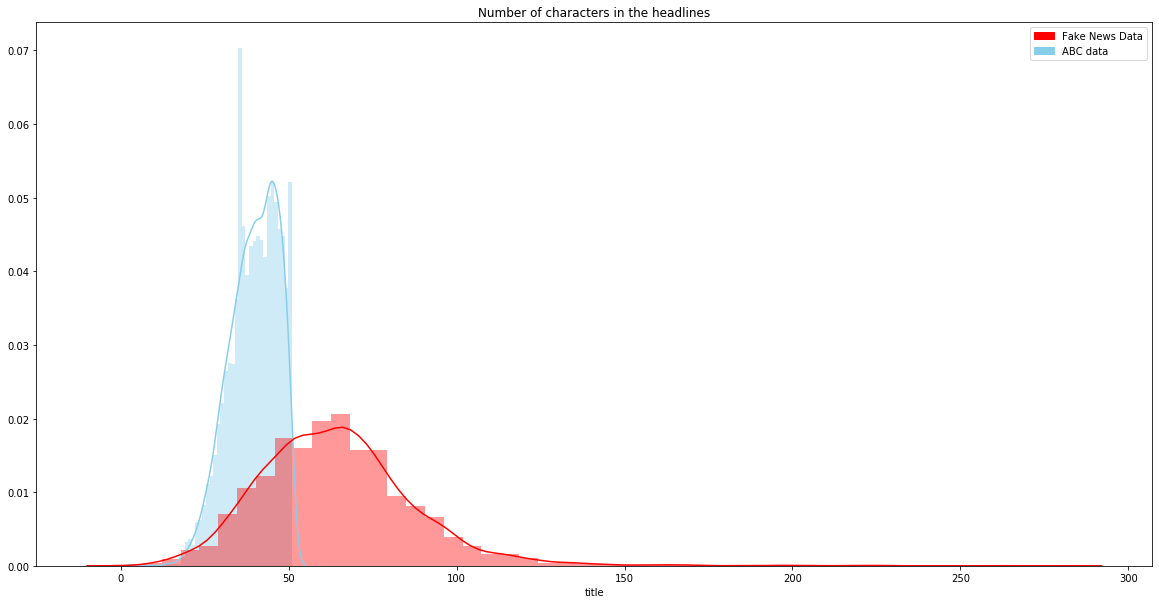

In [284]:
plt.figure(figsize=(20,10))
red_patch = mpatches.Patch(color='red', label='Fake News Data')
blue_patch = mpatches.Patch(color = 'skyblue', label = 'ABC data')
plt.legend(handles=[red_patch, blue_patch])
sns.distplot(news_test_1 , color="skyblue", label="abc data")
sns.distplot( news_1 , color="red", label="fake news data")
plt.title('Number of characters in the headlines')
plt.show()


#plt.legend()

In [285]:
print("The average number of characters in the data corresponding to abc news is: {}".format(np.median(news_test_1)))
print("The average number of characters in the data correspoingin to fake news data is {}".format(np.median(news_1)))
print("The variance of a distribution for the ABC news is {}".format(np.var(news_test_1)))
print("The variance of a distribution for Fake News is {}".format(np.var(news_1)))

The average number of characters in the data corresponding to abc news is: 40.0
The average number of characters in the data correspoingin to fake news data is 63.0
The variance of a distribution for the ABC news is 52.09763585248501
The variance of a distribution for Fake News is 533.7038261895535


Notice the fake news have longer headlines compared to real ones. A title presents the content to be analysed in the article in usually at most 10 words. That is because it is only stated the topic without any further details. Words such as a, an, and, they, etc are avoided as well as unnecessary adjectives and repetitions. For instance, “Great win today of Team A against Team B for the League” is unnecessarily long, while “Team A win” is good enough and all the rest are included in the text.

On the other hand, when one is writing headlines for fake news, he has to make sure that the headline can draw reader’s attention. The use of exclamation marks, 3 dots, capital letters, large numbers and adjectives that show exaggeration is very common in this case. Furthermore, the title usually includes some extra information just to make the reader want to know more about it. For instance, “Elderly woman accused of training her 65 cats to steal from neighbors” is a nice bait to “force” the reader to click on this article.

That explains quite accurately the above graph. Another point to mention is that real news headline’s length has greater consistency while for the fake ones there is bigger standard deviation. This is because writing a proper headline for an article follows some ground rules. On the contrary, fake news headline only requires drawing attention so it does not have a specific formal or structure.

In the plot above we are comparing two data sets. The distribution of numbers of characters in the headlines corresponding to abc news is skewed and the avarage is around 40 characters. Whereas for fake news the average number of characters is 63.

Let's plot the number of words appearing in each news headline. I am going to plot joint distirbution for both data sets.

In [286]:
words_news = news['title'].str.split().\
    map(lambda x: len(x))

In [287]:
words_news_test=news_test['headline_text'].str.split().\
    map(lambda x: len(x))

In [288]:

#f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True)
#sns.distplot( news_1 , color="skyblue", ax=axes[0, 0])
#sns.distplot( news_test_1 , color="olive", ax=axes[0, 1])
#sns.distplot( words_news , color="gold", ax=axes[1, 0])
#sns.distplot( words_news_test , color="teal", ax=axes[1, 1])
#plt.figure(figsize=(20,20))
#plt.show()

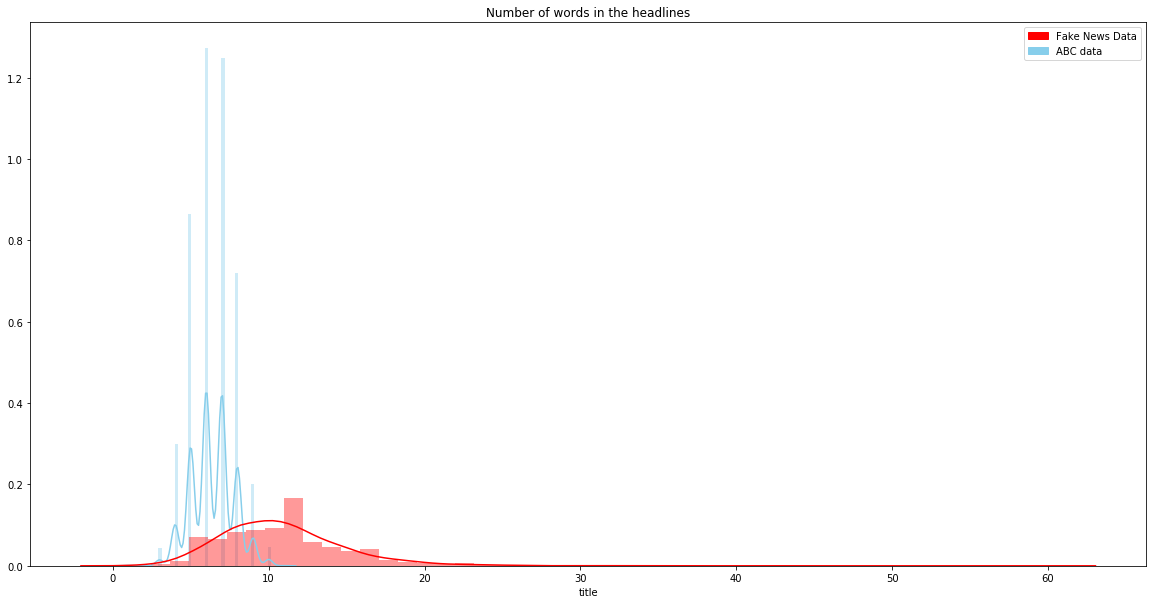

In [289]:
plt.figure(figsize=(20,10))
red_patch = mpatches.Patch(color='red', label='Fake News Data')
blue_patch = mpatches.Patch(color = 'skyblue', label = 'ABC data')
plt.legend(handles=[red_patch, blue_patch])
sns.distplot(words_news_test , color="skyblue", label="abc data")
sns.distplot(words_news , color="red", label="fake news data")
plt.title("Number of words in the headlines")
plt.show()


In [265]:
print("The average number of words in the headlines corresponding to abc news data is: {}".format(np.median(words_news_test)))
print("The average number of words in the headlines corresponding to fake news data is: {}". format(np.median(words_news))) 

The average number of words in the headlines corresponding to abc news data is: 6.0
The average number of words in the headlines corresponding to fake news data is: 10.0


To get the corpus containing stopwords we are going to use the nltk library which contatins stopwords form many languages.
Here, we're going to filter the ENglish stopwords from the corpus.

In [266]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mateusz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [267]:
print("The number of all stopwords in English is {}".format(len(stop)))

The number of all stopwords in English is 179


# Creating the corpus

Let's at this point merge both data frames and perform joint data analysis. Note that the news_test headlines come from austalian tv abc and news come from elsewhere. (Probably USA)

In [290]:
news_test = news_test.rename(columns = {'headline_text':'title'}) #renaming the columns headline_text -> title

In [291]:
news_test.head()

,publish_date,title,label
0,19-02-2003,aba decides against community broadcasting lic...,REAL
1,19-02-2003,act fire witnesses must be aware of defamation,REAL
2,19-02-2003,a g calls for infrastructure protection summit,REAL
3,19-02-2003,air nz staff in aust strike for pay rise,REAL
4,19-02-2003,air nz strike to affect australian travellers,REAL


Let's merge the two data sets and draw some interesting insights out of them

In [292]:
frames = [news, news_test]
results = pd.concat(frames, axis = 0, join = 'outer')
print("The number of rows in a merged data set is {}".format(len(results['title'])))

The number of rows in a merged data set is 12670


/home/mateusz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [293]:
results.head()

,Unnamed: 0,label,publish_date,text,title
0,8476.0,FAKE,NaN,"Daniel Greenfield, a Shillman Journalism Fello...",you can smell hillary s fear
1,10294.0,FAKE,NaN,Google Pinterest Digg Linkedin Reddit Stumbleu...,watch the exact moment paul ryan committed pol...
2,3608.0,REAL,NaN,U.S. Secretary of State John F. Kerry said Mon...,kerry to go to paris in gesture of sympathy
3,10142.0,FAKE,NaN,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",bernie supporters on twitter erupt in anger ag...
4,875.0,REAL,NaN,It's primary day in New York and front-runners...,the battle of new york why this primary matters


In [294]:
corpus = []
new =results['title'].str.split()
new = new.values.tolist()
corpus=[word for i in new for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

In [295]:
from collections import Counter
import seaborn as sns

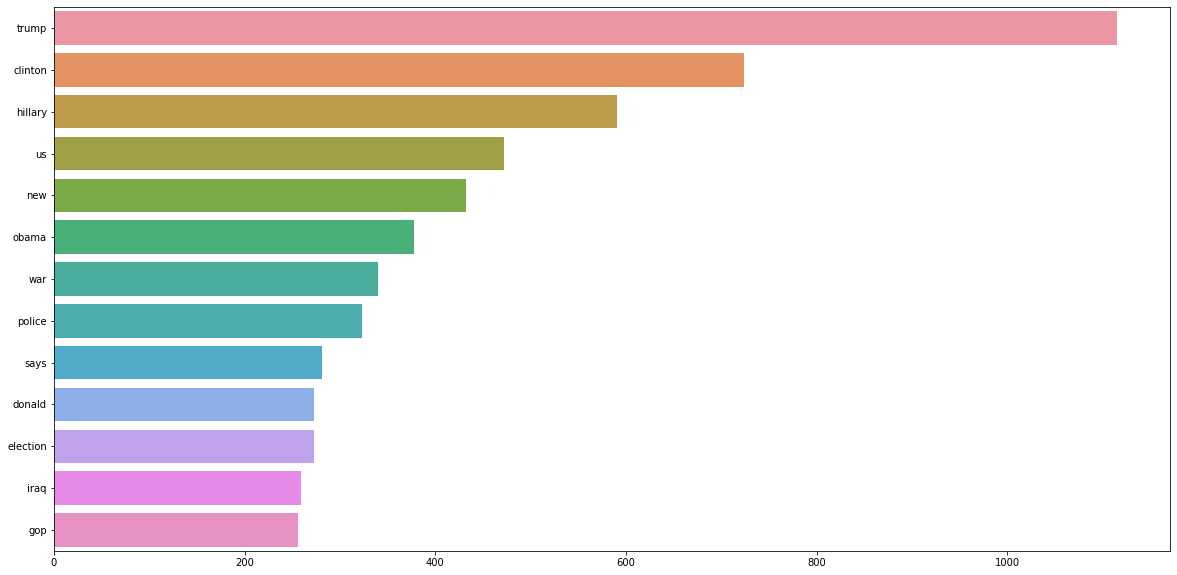

In [296]:
counter=Counter(corpus)
most=counter.most_common()

x, y = [], []
for word, count in most[:40]:
    if (word not in stop):
        y.append(word)
        x.append(count)
plt.figure(figsize=(20,10))        
sns.barplot(x=x, y=y)

This graph can be misleading. It seems that the word “trump” appears too many times and one can guess that it refers to Donald Trump. By making a quick search on the data we can observe that this is not always that case. We find many words such as “trumpet”, “trumped”, “trumper”, “trumps”, etc. Same thing applies for the word “clinton”. One can guess that it refers to Hillary Clinton, which is true for most cases but not for all of them. Again, by doing some search we can see that it can also be Bill Clinton or sometimes it is just Clinton without specifying for which one of them it refers to. Furthermore, notice the word “us” in the fourth place which can either refer to the country USA or it could just mean ourselves. Overall though, in most cases it refers to Donald Trump, Hillary Clinton and USA.

Another very important point we need to make here is that we observe other key words such as “Obama”, “war”, “Iraq”, “police”, “election”, etc. We can easily conclude that the majority of articles have serious political content related to crime, violence, war, propaganda, foreign policy, etc. These are the main topics where fake news are spotted. All the above-mentioned subjects are controversial due to people with different political beliefs may have different opinions around them. In addition, it is usually quite hard for one to know all the facts about an incident and so even harder to distinguish between real and fake facts. Moreover, these are all sensitive issues and the most naïve ones can easily get fanatic about them just because they believe some fake news they read. With these arguments we can justify the high proportion of fake news in our data. 

# Ngram exploration

In [297]:
from nltk.util import ngrams

To build a representation of our vocabulary we will use Countervectorizer which is a simple method used to tokenize, vectorize and represent the corpus in an appropriate form.

In [298]:
from sklearn.feature_extraction.text import CountVectorizer

In [299]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq=sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

The top 5 bigrams

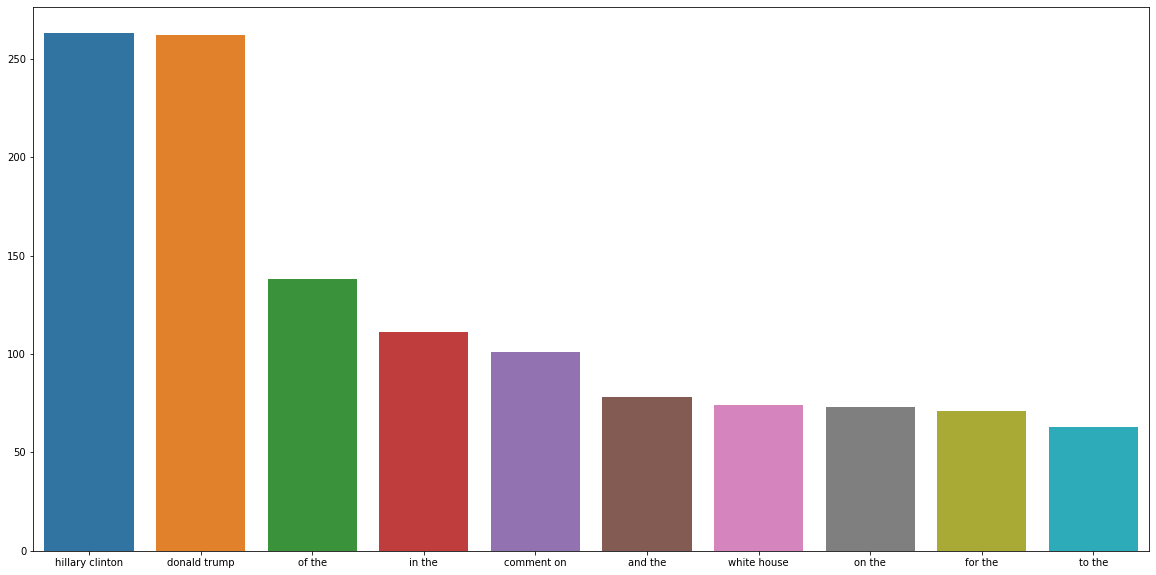

In [300]:
top_n_bigrams=get_top_ngram(news['title'],2)[:10]
x, y=map(list,zip(*top_n_bigrams))
plt.figure(figsize=(20,10))
sns.barplot(x=x, y=y)

This graph does not contain anything surprising; it has what we expected. The top bigrams are of course Hillary Clinton and Donald Trump. The rest are just stop words apart from the “White House”. We cannot draw any new conclusions as bigrams such as “on the” or “and the” would appear pretty much everywhere. However, the next graph contains more meaningful information.

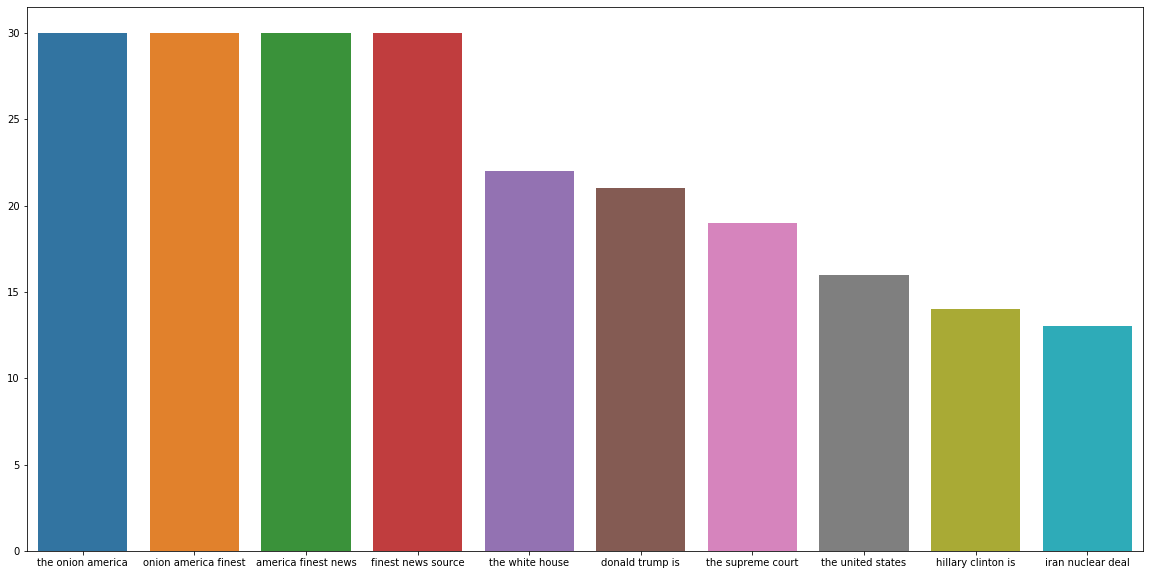

In [301]:
top_n_trigrams = get_top_ngram(news['title'],3)[:10]
x, y=map(list, zip(*top_n_trigrams))
plt.figure(figsize=(20,10))
sns.barplot(x=x, y=y)

The top trigrams have to do with “The Onion”. This is an American journalistic site which calls itself “America’s Finest News Source”.  Just by reading a few headlines in its home page and conducting a quick research one can realise that all its news is fake. Apparently, its only purpose is to make satire, making fun of both Democrats and Republicans. It is one of the most popular websites for fake news on the internet and so their income comes from online advertising. Anyone who does not have critical thinking and does not know what “The Onion” is all about can mistake it for a reliable source of information. 

This reinforces the previous argument that it is easier to create fake news for political topics compared to any other. When we started searching about The Onion we did not know what it is about but we started realising something is not right when we read a sport’s headline. Whatever happens to sports is a clear fact, so it is much harder to produce fake news for this kind of topic.

# Topic modelling exploration with pyLDAvis

Topic modelling is the process of using unsupervised learning techniques to extract the main topics that occur in a collection of documents

Latent Dirichlet Allocation (LDA) is an easy to use and efficient model for topic modelling. Each document is represented by the distribution of topics and each topic is represented by the distribution of words.

Before we get into topic modelling we should pre-process the data by:
    tokenizing: sentences are converted to a list of tokens or words
    removing stopwords
    lemmatizing - reducing the inflectional forms of each word into a common base or root
    converting to the bag of words - bag-of-words is a dictionary where the keys are words (or ngrams/tokens) and values are the number of times each word occurs in the corpus https://machinelearningmastery.com/gentle-introduction-bag-words-model/

In [302]:
import nltk
nltk.download("punkt")
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/mateusz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mateusz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [303]:
from nltk.tokenize import word_tokenize

Tokenizing and lemmatizing

In [304]:
def preprocess_news(df):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for news in df['title']:
        words =[w for w in word_tokenize(news) if (w not in stop)] #list comprehension returns tokens of the headlines which are not stopwords
        
        words=[lem.lemmatize(w) for w in words if len(w)>2] #returns lemmatized words of length greater than 2 (ensuring that doesn;t conatain stopwords)
        
        
        corpus.append(words) #append words to the corpus
        
    return corpus
corpus=preprocess_news(results)

We got tokenized sentences. Explain what thtat is.

Creating bug-of-words using gensim. Read the gensim documentation and about bag of words

In [305]:
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

Creating the LDA model

In [306]:
import time
t = time.time()
lda_model = gensim.models.LdaMulticore(bow_corpus,
                                      num_topics = 4,
                                      id2word = dic,
                                      passes = 10,
                                      workers = 2)
lda_model.show_topics()
print("Time to create LDA model: {} mins".format(round((time.time () - t )/ 60,2 )))

Time to create LDA model: 1.01 mins


Read on LDA model

In [307]:
t= time.time()
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
vis

print("Time to create pyLDAvis plot: {} mins".format(round((time.time() - t)/ 60,2)))

Time to create pyLDAvis plot: 6.67 mins


/home/mateusz/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Things to bear in mind:
- area of each cirlce represents the importance of the topic relative to the corpus
- distance between the center of the circles indicates the similarity between the topis
- the histogram on the righ side shows the top 30 relevant words for each topic.

# Using Textblob for sentiment analysis.

The sentiment function of TextBlob returns two properties:

- polarity: floating point number that lies in the range of [-1,1], where 1 means positive statement and -1 means a negative statement.
- subjectivity: refers to how someone's jugdment is shaped by personal opinions and feelings. Floating point value between [0,1]

In [308]:
from textblob import TextBlob

Polarity of the two data sets

In [316]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

news['polarity_score']=news['title'].\
    apply(lambda x: polarity(x))
news_test['polarity_score']=news_test['title'].\
    apply(lambda x: polarity(x))

Polarity and subjectivity of the text in Fake News Data. 

In [ ]:
news['polarity_score_text']=news['text'].\
    apply(lambda x: polarity(x))
news_test['polarity_score_text'].hist()

In [ ]:
real = news[news['label'].str.contains("REAL")]
fake = news[news['label'].str.contains("FAKE")]

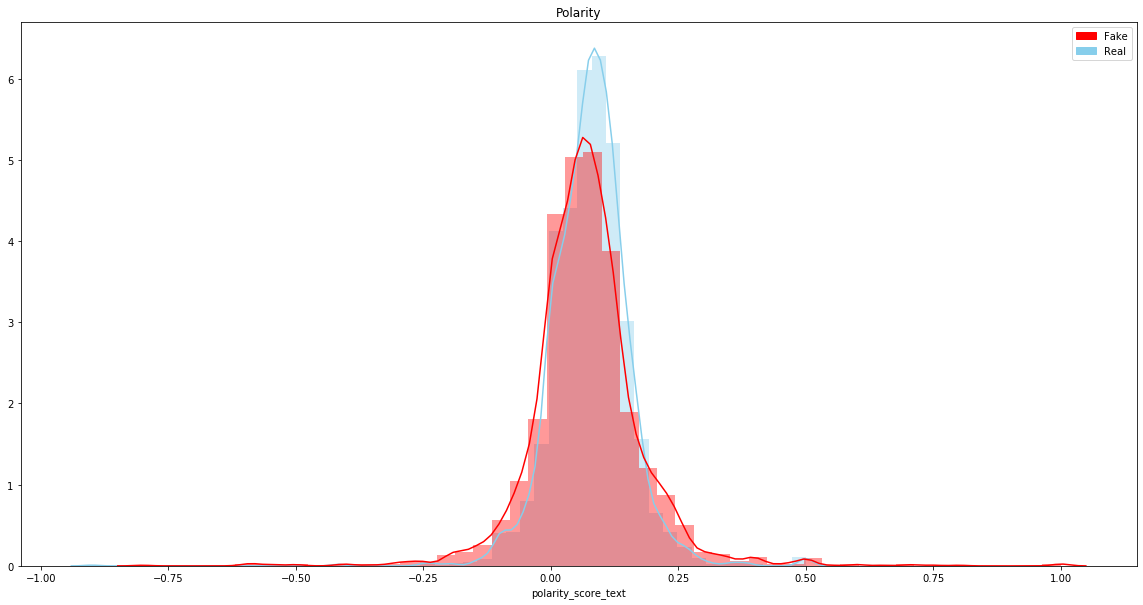

In [208]:
plt.figure(figsize=(20,10))
red_patch = mpatches.Patch(color='red', label='Fake')
blue_patch = mpatches.Patch(color = 'skyblue', label = 'Real')
plt.legend(handles=[red_patch, blue_patch])
sns.distplot(real['polarity_score_text'] , color="skyblue", label="Real")
sns.distplot(fake['polarity_score_text'] , color="red", label="Fake")
plt.title("Polarity")
plt.show()

It turns out that Real news are more positive but both are considered to be neutral.

In [221]:
print("Average value of Polarity score of real news {}".format(np.mean(real['polarity_score_text'])))
print("Average value of Polarity score of fake news {}".format(np.mean(fake['polarity_score_text'])))
print("The difference in those values is {}".format((np.mean(real['polarity_score_text']))- np.mean(fake['polarity_score_text'])))
print("The maximum value of polarity score for real data is {}".format(np.max(real["polarity_score_text"])))
print("The maximum value of polarity score for fake data is {}".format(np.max(fake["polarity_score_text"])))
print("The minimum value of polarity score for fake data is {}".format(np.min(fake["polarity_score_text"])))
print("The minimum value of polarity score for fake data is {}".format(np.min(fake["polarity_score_text"])))



Average value of Polarity score of real news 0.07809378802566116
Average value of Polarity score of fake news 0.07016365283313525
The difference in those values is 0.007930135192525917
The maximum value of polarity score for real data is 0.5
The maximum value of polarity score for fake data is 1.0
The minimum value of polarity score for fake data is -0.8
The minimum value of polarity score for fake data is -0.8


In [222]:
def subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

Subjectivity for the training data

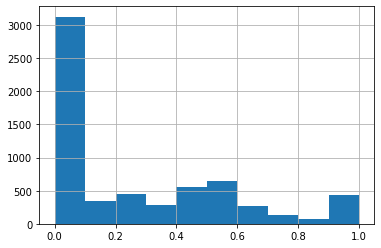

In [223]:
news['subjectivity_score']=news['title'].\
    apply(lambda x: subjectivity(x))
news['subjectivity_score'].hist()

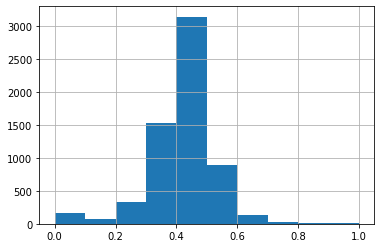

In [224]:
news['subjectivity_score_text']=news['text'].\
    apply(lambda x: subjectivity(x))
news['subjectivity_score_text'].hist()

We can see that the subjectivity score of the text is larger. Is the algorithm more reliable on the larger subsets?

Let's see how the distribution varies between fake and real news

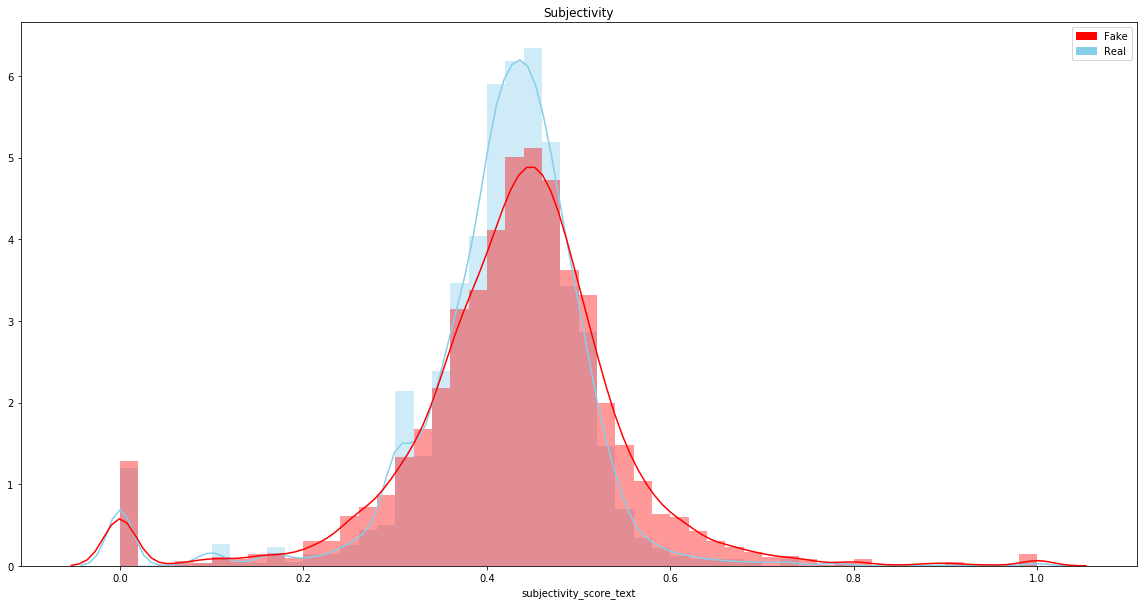

In [225]:
plt.figure(figsize=(20,10))
red_patch = mpatches.Patch(color='red', label='Fake')
blue_patch = mpatches.Patch(color = 'skyblue', label = 'Real')
plt.legend(handles=[red_patch, blue_patch])
sns.distplot(real['subjectivity_score_text'] , color="skyblue", label="Real")
sns.distplot(fake['subjectivity_score_text'] , color="red", label="Fake")
plt.title("Subjectivity")
plt.show()

Subjectivity score for real text is more confident - smaller variance.

In [235]:
print("Variance of subjectivity score for real text is {}".format(np.var(real['subjectivity_score_text'])))
print("Variance of subjectivity score for fake text is {}".format(np.var(fake['subjectivity_score_text'])))

Variance of subjectivity score for real text is 0.010541626560985588
Variance of subjectivity score for fake text is 0.015220690067818619


In [206]:
print("The average subjectivity of real is {}".format(np.mean(real['subjectivity_score_text'])))
print("The average subjectivity of fake is {}".format(np.mean(fake['subjectivity_score_text'])))

The average subjectivity of real is 0.41387922554437495
The average subjectivity of fake is 0.4280131230720351


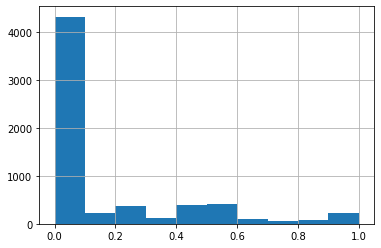

In [237]:
news_test['subjectivity_score']=news_test['headline_text'].\
    apply(lambda x: subjectivity(x))
news_test['subjectivity_score'].hist()

Plot those together. https://python-graph-gallery.com/25-histogram-with-several-variables-seaborn/

The above plot indicates that the majority of headlines have polarity score between 0 and 0.25. They are neutral with more leaning toward positive sentiments.

In [238]:
def sentiment(x):
    if x<0:
        return 'negative'
    elif x==0:
        return 'neutral'
    else:
        return 'positive'
    
news['polarity']=news['polarity_score'].\
    map(lambda x: sentiment(x))
news_test['polarity']=news_test['polarity_score'].\
    map(lambda x: sentiment(x))

<BarContainer object of 3 artists>

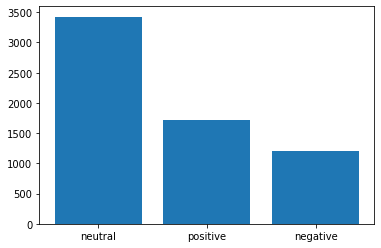

In [239]:
plt.bar(news.polarity.value_counts().index,
       news.polarity.value_counts())

<BarContainer object of 3 artists>

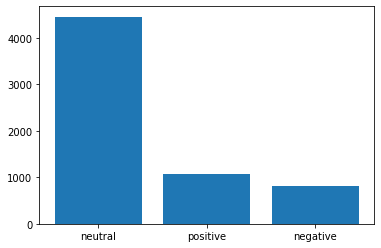

In [241]:
plt.bar(news_test.polarity.value_counts().index,
       news_test.polarity.value_counts())

Let's check how the positive and negative headlines are like

In [244]:
news[news['polarity']=='positive']['title'].head()

1     watch the exact moment paul ryan committed pol...
4       the battle of new york why this primary matters
9     iran reportedly makes new push for uranium con...
12    strong solar storm tech risks today s0 news oc...
14                      trump takes on cruz but lightly
Name: title, dtype: object

In [245]:
news[news['polarity']=='negative']['title'].head()

3     bernie supporters on twitter erupt in anger ag...
11    donald trump s shockingly weak delegate game s...
16    shocking michele obama hillary caught glamoriz...
17    hillary clinton in huge trouble after america ...
23    new senate majority leader s main goal for gop...
Name: title, dtype: object

Now, we are going to use Vader Sentient Analisis which is said to be working better in detecting negative sentiment.
returns a dictionary that contains the probabilities of the text for being positive, negative and neutral.

In [246]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/mateusz/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<BarContainer object of 3 artists>

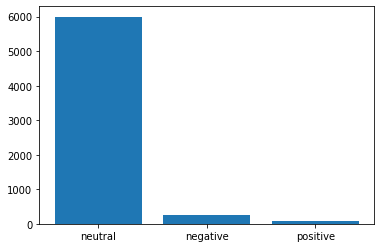

In [253]:
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

def get_vader_score(sent):
    #polarity score return dictionary
    ss= sid.polarity_scores(sent)
    #return ss
    return np.argmax(list(ss.values())[:-1])

news['polarity']=news['title'].\
    map(lambda x: get_vader_score(x))
polarity=news['polarity'].replace({0:'negative', 1:'neutral', 2:'positive'})

plt.bar(polarity.value_counts().index,
        polarity.value_counts())

Comparing Vader and TextBlob. Vader classifies even more headlines as neutral

Named Entity Recognition

Information extraction method in which entities that are present in the text are classified into predefined entity types like "person", "Place","Organization" etc.


There are three standard libraries for Named Entity recognition:
    - Standford NER
    - spaCy
    - NLTK

Here, we are going to use spaCy.
First in command window type it: pip install spacy 

and then


python -m spacy download en_core_web_sm

In [256]:
import spacy

nlp = spacy.load("en")

Let's run the NER on our news headlines and store the entity types

In [258]:
t=time.time()
def ner(text):
    doc=nlp(text)
    return [x.label_ for x in doc.ents]

ent=results["title"].\
    apply(lambda x: ner(x))
ent=[x for sub in ent for x in sub]

counter = Counter(ent)
count=counter.most_common()
print("Time to run this bit of code is {}".format(round(t-time.time())/60,2))

TypeError: object of type 'float' has no len()

Visualize the entity frequencies for both data sets.

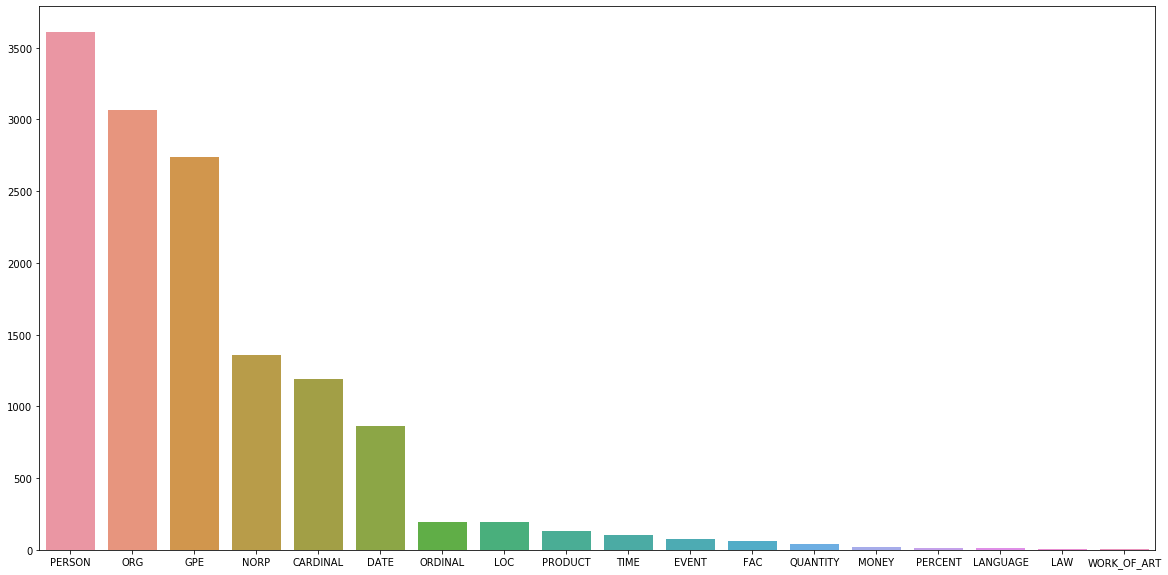

In [104]:
x,y=map(list,zip(*count)) #change figsize
plt.figure(figsize=(20,10))
sns.barplot(x=x,y=y)

Vizualizing the most common tokes per entity.

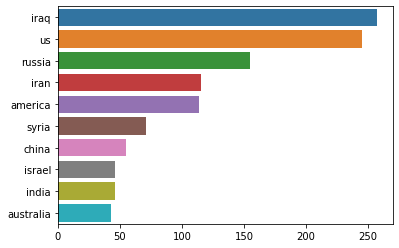

In [106]:
def ner(text,ent="GPE"):
    doc=nlp(text)
    return [x.text for x in doc.ents if x.label_ == ent]

gpe=results['title'].apply(lambda x: ner(x))
gpe=[i for x in gpe for i in x]
counter = Counter(gpe)

x,y=map(list,zip(*counter.most_common(10)))
sns.barplot(y,x)

IDEA: plot sentiment associated with a person, place etc. avg sentiment for the most often occuring names

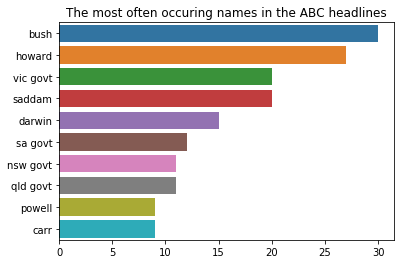

In [107]:
def ner(text, ent='PERSON'):
    doc=nlp(text)
    return [x.text for x in doc.ents if x.label_ == ent]

person=news_test['title'].apply(lambda x: ner(x))
person=[i for x in person for i in x]
counter = Counter(person)

x,y=map(list,zip(*counter.most_common(10)))
plt.title('The most often occuring names in the ABC headlines')
sns.barplot(y,x)


# Distribution of subjectivity for ABC data and Fake News Data

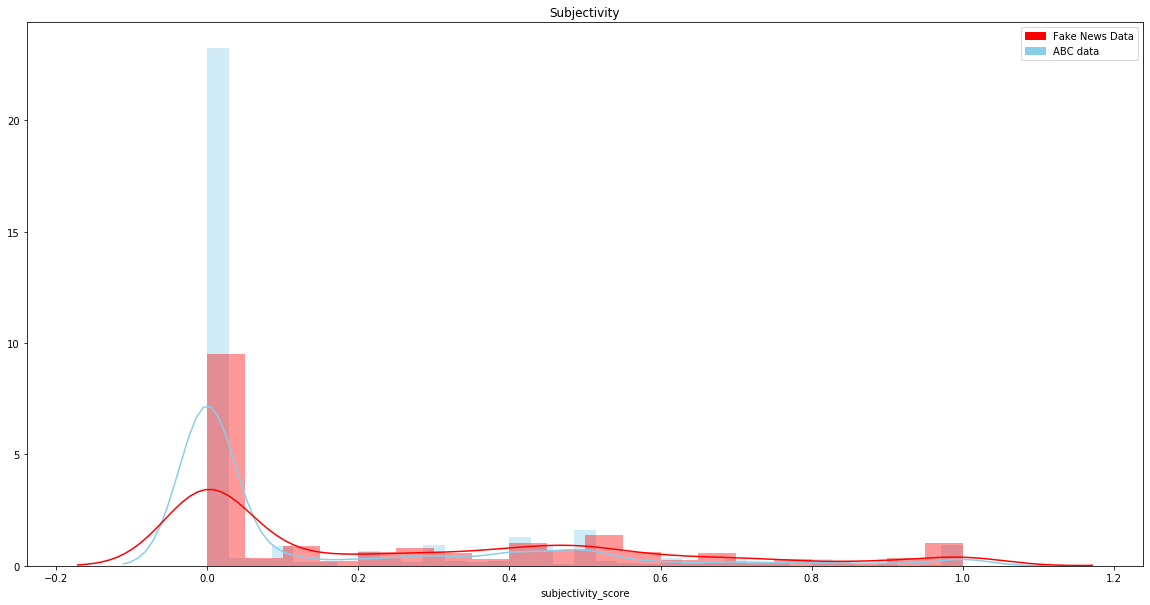

In [158]:
plt.figure(figsize=(20,10))
red_patch = mpatches.Patch(color='red', label='Fake News Data')
blue_patch = mpatches.Patch(color = 'skyblue', label = 'ABC data')
plt.legend(handles=[red_patch, blue_patch])
sns.distplot(news_test['subjectivity_score'] , color="skyblue", label="abc data")
sns.distplot(news['subjectivity_score'] , color="red", label="fake news data")
plt.title("Subjectivity")
plt.show()

In [159]:
a = np.mean(news_test['polarity_score'])
b = np.mean(news['polarity_score'])
print('The ABC news average polarity is: {}'.format(a))
print("The fake news headlines' polarity is: {}".format(b))
# the headlines tend to be more positive but are rather nutral

The ABC news average polarity is: 0.02126323417148199
The fake news headlines' polarity is: 0.023999235945054542


The polarity of the two data sets is similar.

In [160]:
a=np.mean(news_test['subjectivity_score'])
b=np.mean(news['subjectivity_score'])
print('The ABC news average subjectivity is: {}'.format(a))
print('The fake news headline data average subjectivity is {}'.format(b))

The ABC news average subjectivity is: 0.15097761780299274
The fake news headline data average subjectivity is 0.2543205272175289


It's seen that the fake news average subjectivity is higher.

We can see that subjectivity for Fake News Data is more rightly skewed with longer right tail, but both distributions resemble standrard normal distribution

# Subjectivity of Real and Fake headlines

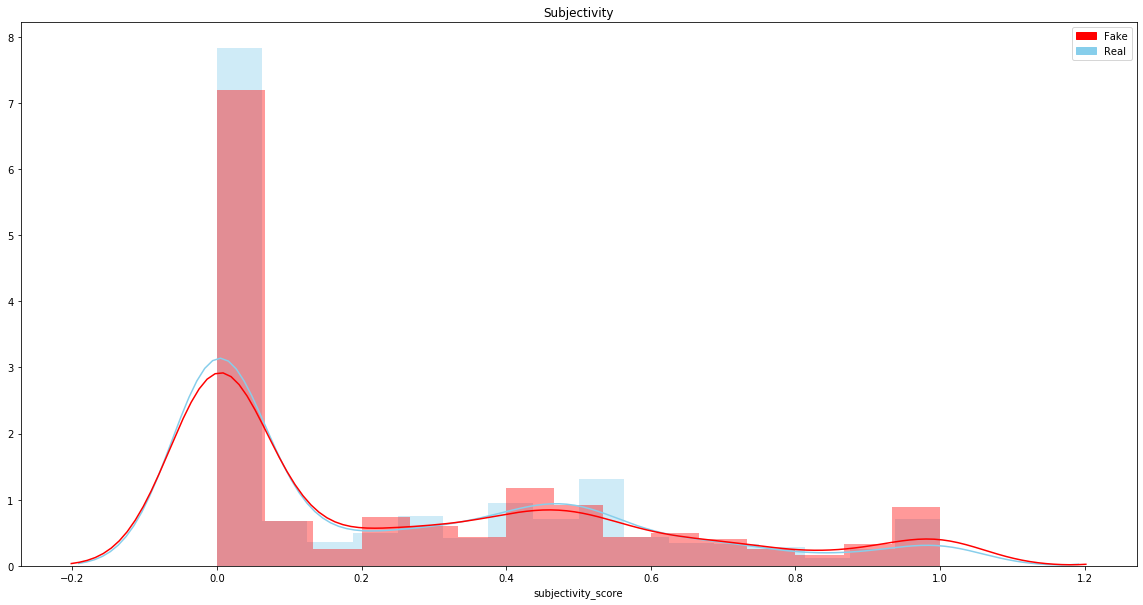

In [157]:
real = news[news['label'].str.contains("REAL")]
fake = news[news['label'].str.contains("FAKE")]

plt.figure(figsize=(20,10))
red_patch = mpatches.Patch(color='red', label='Fake')
blue_patch = mpatches.Patch(color = 'skyblue', label = 'Real')
plt.legend(handles=[red_patch, blue_patch])
sns.distplot(real['subjectivity_score'] , color="skyblue", label="Real")
sns.distplot(fake['subjectivity_score'] , color="red", label="Fake")
plt.title("Subjectivity")
plt.show()

We can see that distribution of subjectivity for both Fake and Real is the same.

In [146]:
news_test[news_test['title'].str.contains("bush")]
#news_test['polarity_score'].where(news_test['title']=='Bush')

,publish_date,title,label,polarity_score,subjectivity_score,polarity
19,19-02-2003,bushfire victims urged to see centrelink,REAL,0.000000,0.000000,neutral
157,19-02-2003,safety review begins after bushwalker death,REAL,0.000000,0.000000,neutral
220,20-02-2003,bushfire coronial inquiry winds up,REAL,0.000000,0.000000,neutral
221,20-02-2003,bush thanks nato for support on turkey,REAL,0.200000,0.200000,positive
343,20-02-2003,nats seek probe bushfires probe,REAL,0.000000,0.000000,neutral
...,...,...,...,...,...,...
5768,19-03-2003,bushfire victims gets advice hotline,REAL,0.000000,0.000000,neutral
5994,20-03-2003,bush declares war on iraq,REAL,0.000000,0.000000,neutral
6036,20-03-2003,full text bush declares war has begun,REAL,0.350000,0.550000,positive
6097,20-03-2003,new bush nursing centre opens,REAL,0.136364,0.454545,positive


# How polarity was changing over time for ABC news data

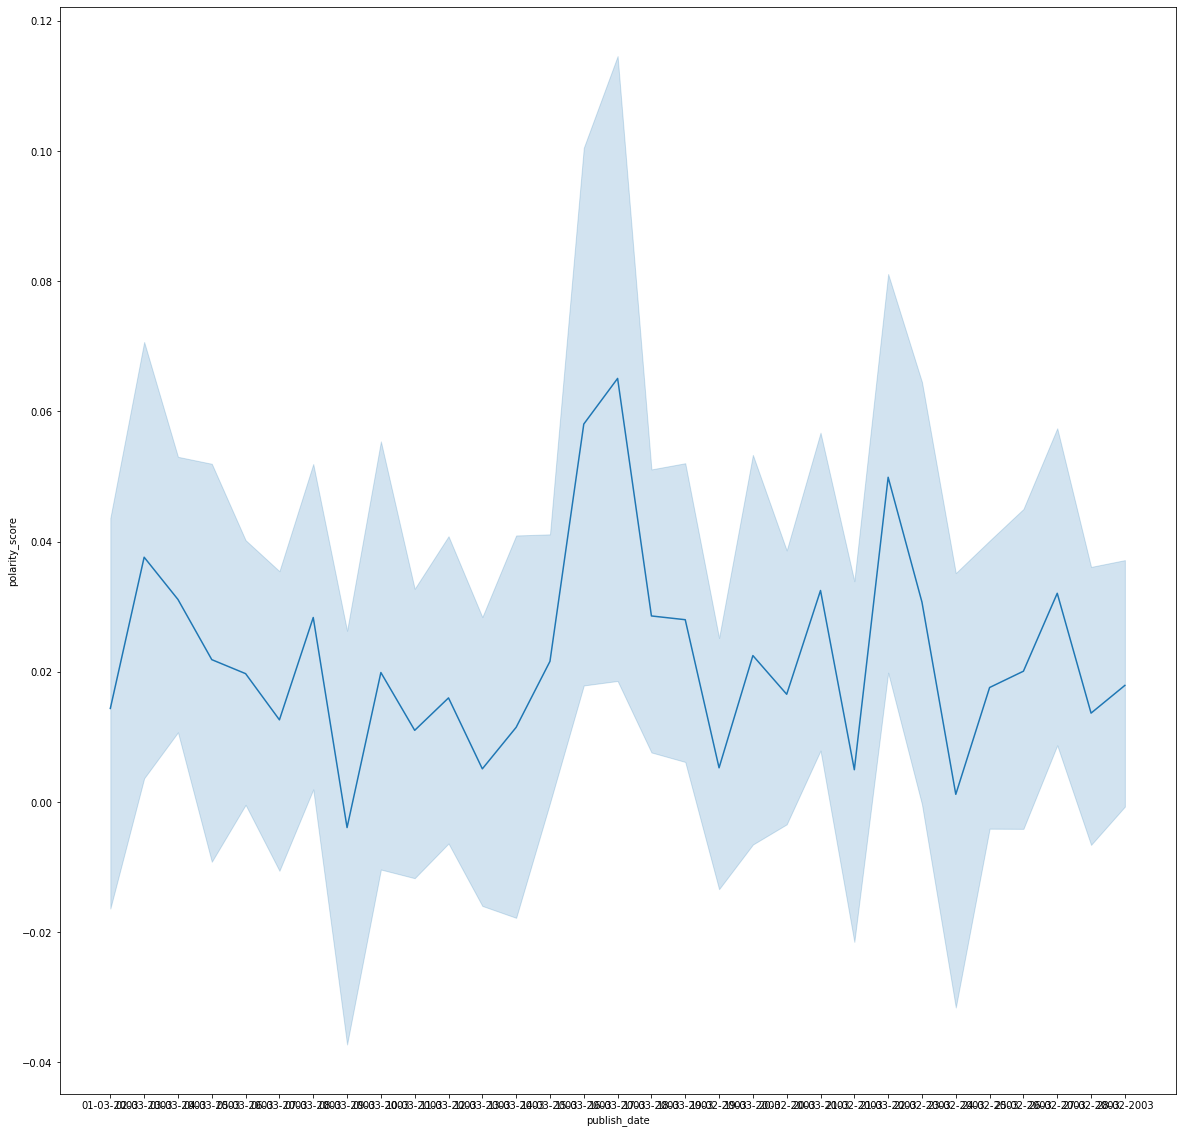

In [121]:
plt.figure(figsize=(20,20))
sns.lineplot(x=news_test['publish_date'], y=news_test['polarity_score'])

In [116]:
news_test

,publish_date,title,label,polarity_score,subjectivity_score,polarity
0,19-02-2003,aba decides against community broadcasting lic...,REAL,0.00,0.000000,neutral
1,19-02-2003,act fire witnesses must be aware of defamation,REAL,0.25,0.250000,positive
2,19-02-2003,a g calls for infrastructure protection summit,REAL,0.00,0.000000,neutral
3,19-02-2003,air nz staff in aust strike for pay rise,REAL,0.00,0.000000,neutral
4,19-02-2003,air nz strike to affect australian travellers,REAL,0.00,0.000000,neutral
...,...,...,...,...,...,...
6330,21-03-2003,prepare for longer war downer,REAL,0.00,0.000000,neutral
6331,21-03-2003,protesters gather for second day of marches,REAL,0.00,0.000000,neutral
6332,21-03-2003,public prepare to cast votes in nsw poll,REAL,0.00,0.066667,neutral
6333,21-03-2003,qantaslink to boost rockhampton gladstone flights,REAL,0.00,0.000000,neutral


In [110]:
#spaghetti plot for sentiments associated with people. change the code
# libraries and data
#import matplotlib.pyplot as plt
#import numpy as np
#import pandas as pd
 
# Make a data frame
#df=pd.DataFrame({'x': range(1,11), 'y1': np.random.randn(10), 'y2': np.random.randn(10)+range(1,11), 'y3': np.random.randn(10)+range(11,21), 'y4': np.random.randn(10)+range(6,16), 'y5': np.random.randn(10)+range(4,14)+(0,0,0,0,0,0,0,-3,-8,-6), 'y6': np.random.randn(10)+range(2,12), 'y7': np.random.randn(10)+range(5,15), 'y8': np.random.randn(10)+range(4,14), 'y9': np.random.randn(10)+range(4,14), 'y10': np.random.randn(10)+range(2,12) })
 
# style
#plt.style.use('seaborn-darkgrid')
 
# create a color palette
#palette = plt.get_cmap('Set1')
 
# multiple line plot
#num=0
#for column in df.drop('x', axis=1):
#num+=1
#plt.plot(df['x'], df[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label=column)
 
# Add legend
#plt.legend(loc=2, ncol=2)
 
# Add titles
#plt.title("A (bad) Spaghetti plot", loc='left', fontsize=12, fontweight=0, color='orange')
#plt.xlabel("Time")
#plt.ylabel("Score")

In [111]:
news.head()

,Unnamed: 0,title,text,label,polarity_score,subjectivity_score,polarity
0,8476,you can smell hillary s fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,0.000000,0.000000,1
1,10294,watch the exact moment paul ryan committed pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,0.125000,0.175000,1
2,3608,kerry to go to paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,0.000000,0.000000,1
3,10142,bernie supporters on twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,-0.700000,0.200000,1
4,875,the battle of new york why this primary matters,It's primary day in New York and front-runners...,REAL,0.268182,0.477273,1


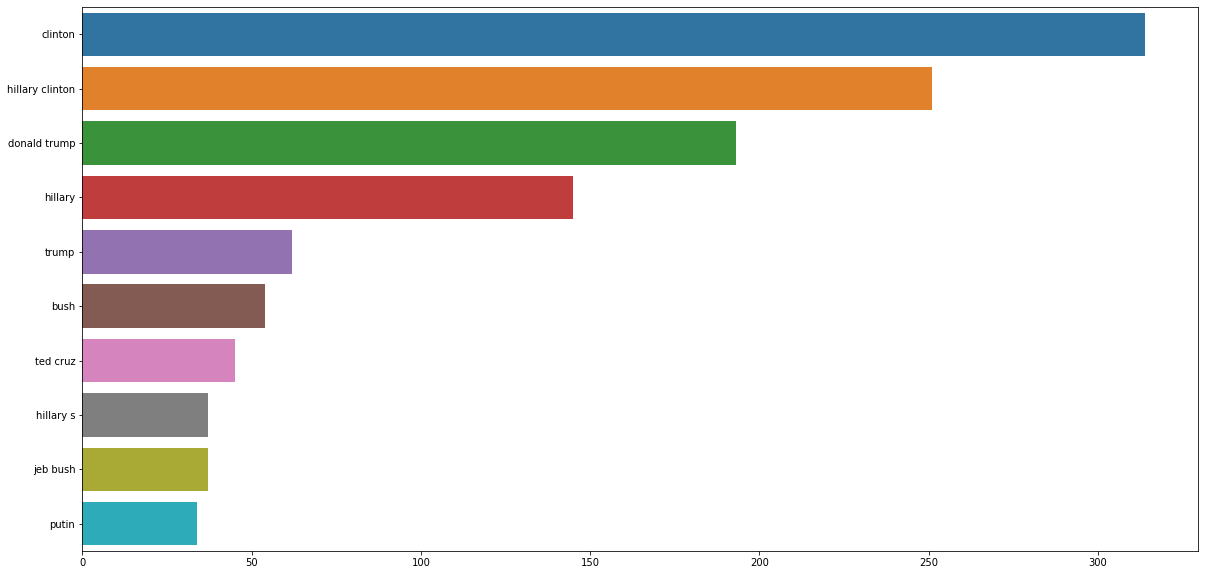

In [112]:
per = results['title'].apply(lambda x: ner(x,"PERSON"))
per=[i for x in per for i in x]
counter=Counter(per)

x,y=map(list,zip(*counter.most_common(10)))
plt.figure(figsize=(20,10))
sns.barplot(y,x)

Plot sentiment over time for name Bush, Sadam, Howard

CHECK: Models classifies gvt incorrectly.

Using Parts of Speach Tagging for data exploration

Parts of speech (POS) tagging is a method that assigns part of speech labels to words in a sentence. There are eight main parts of speech:

    Noun (NN)- Joseph, London, table, cat, teacher, pen, city
    Verb (VB)- read, speak, run, eat, play, live, walk, have, like, are, is
    Adjective(JJ)- beautiful, happy, sad, young, fun, three
    Adverb(RB)- slowly, quietly, very, always, never, too, well, tomorrow
    Preposition (IN)- at, on, in, from, with, near, between, about, under
    Conjunction (CC)- and, or, but, because, so, yet, unless, since, if
    Pronoun(PRP)- I, you, we, they, he, she, it, me, us, them, him, her, this
    Interjection (INT)- Ouch! Wow! Great! Help! Oh! Hey! Hi!

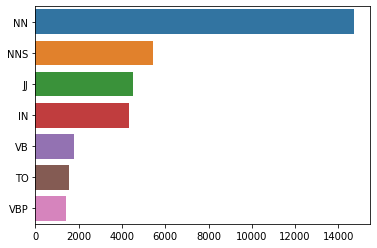

In [113]:
import nltk
def pos(text):
    pos=nltk.pos_tag(word_tokenize(text))
    pos=list(map(list,zip(*pos)))[1]
    return pos

tags=news_test['title'].apply(lambda x: pos(x))
tags=[x for l in tags for x in l]
counter=Counter(tags)

x,y=list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y, y=x)

Let's check which single noun occur most frequently in news headlines.

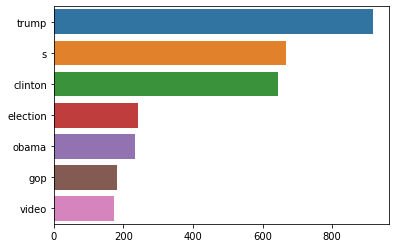

In [114]:
def get_adjs(text):
    adj=[]
    pos=nltk.pos_tag(word_tokenize(text))
    for word, tag in pos:
        if tag=='NN':
            adj.append(word)
    return adj
        
words=news['title'].apply(lambda x : get_adjs(x))
words=[x for l in words for x in l]
counter=Counter(words)

x,y=list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y, y=x)

Exploring through text complexity.
Readability index is a numeric value that indicates how difficult (or easy) it is to read and understand a text.

Some readability indices:
Automated Readability Index (ARI): 	The output is an approximate representation of the U.S grade level needed to comprehend a text. 	
ARI = 4.71 * (characters/words) + 0.5 * (words/sentence) -21.43

Flesch Reading Ease (FRE): 	Higher scores indicate material that is easier to read, lower numbers mark harder-to-read passages:
- 0-30 College
- 50-60 High school
- 60+ Fourth grade 	FRE = 206.835 − 1.015 * (total words/total sentences)
− 84.6 * (total syllables/ total words)

FleschKincaid Grade Level (FKGL): The result is a number that corresponds with a U.S grade level. 	
FKGL = 0.39 * (total words/ totalsentences) + 11.8 (total syllables/total words) -15.59

Gunning Fog Index (GFI): 	The result is a number that corresponds with a U.S grade level. 	
GFI = 0.4 * (( words/ sentence)+100 * (complex words/ words))

We are going to use Textstat that provides implementation of all these text statistics calculation methods.
Let's try and implement Flesch Reading Ease index.

Before we do it. in your command window type in: pip install textstat

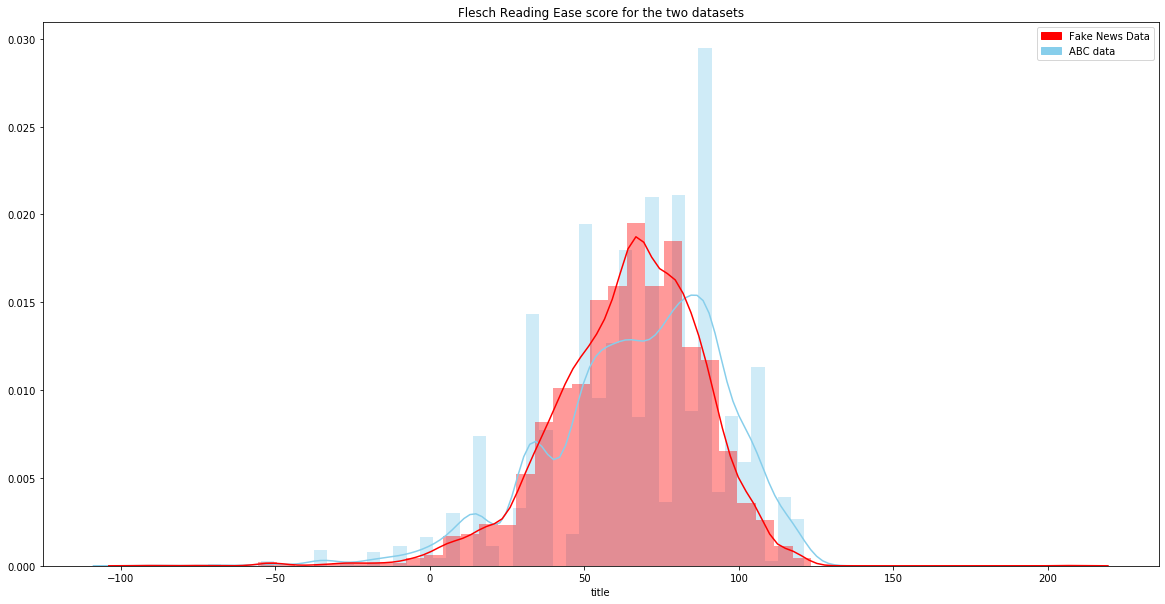

In [115]:
from textstat import flesch_reading_ease

a=news['title'].\
    apply(lambda x: flesch_reading_ease(x))
b=news_test['title'].\
    apply(lambda x: flesch_reading_ease(x))




plt.figure(figsize=(20,10))
red_patch = mpatches.Patch(color='red', label='Fake News Data')
blue_patch = mpatches.Patch(color = 'skyblue', label = 'ABC data')
plt.legend(handles=[red_patch, blue_patch])
sns.distplot(b , color="skyblue", label="abc data")
sns.distplot( a , color="red", label="fake news data")
plt.title('Flesch Reading Ease score for the two datasets')
plt.show()


The lower the score, the harder the text to comprehend.

Almost all of the readability scores fall above 60. This means that an average 11-year-old student can read and understand the news headlines.
Let's check all news headlines that have a readability score below 5

In [178]:
#x=[i for i in range(len(reading)) if reading[i]< 5]
#news.iloc[x]['headline_text'].head()

In [279]:
import itertools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score

Let's assign value 1 to REAL label and 0 to FAKE

In [283]:
results['label'] = results.apply(lambda x: 0 if 'FAKE' in x['label'] else 1, axis=1) 
#if the labels have been already assigned, it may throw an error

TypeError: ("argument of type 'int' is not iterable", 'occurred at index 0')

In [285]:
results['label'].value_counts()

1    9506
0    3164
Name: label, dtype: int64

Imbalanced data set. Sampling?

Let's try first approach, merging two data sets and perform train test split

In [298]:
x_train,x_test, y_train, y_test = train_test_split(results['title'], results['label'], test_size =0.5, random_state= 12231)

initialize tfidVectorizer

In [299]:
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', max_df=0.7)

tfidf_train=tfidf_vectorizer.fit_transform(x_train)
tfidf_test=tfidf_vectorizer.transform(x_test)

In [300]:
#Initialize a PassiveAggressiveClassifier
pac=PassiveAggressiveClassifier(max_iter=100)
pac.fit(tfidf_train, y_train)

#Predict on the test set and calculate score
y_pred=pac.predict(tfidf_test)
score = accuracy_score(y_test, y_pred)
f1score=f1_score(y_test, y_pred)
aucscore=roc_auc_score(y_test, y_pred)
print(f'Accuracy: {round(score*100,2)}%')
print(f' F1 score: {(f1score)}%')
print(f' AUC score:{(aucscore)}%')

Accuracy: 85.04%
 F1 score: 0.9018836679776444%
 AUC score:0.7842087805091106%


Accuracy is the number of correctly predicted data points, devided by the number of all data. Since, the data is inbalanced, this metric is not reliable.
F1 score is a harmonic mean of precision and recall. It's a good metric when dealing with imbalanced data sets.
AUC score: the area under the ROC curve.

Investigating distribution of the testing set

In [295]:
(y_test==0).value_counts()

False    4756
True     1579
Name: label, dtype: int64

In [296]:
#Confusion matrix
confusion_matrix(y_test, y_pred, labels=[0,1])

array([[1029,  550],
       [ 391, 4365]])

In [309]:
from sklearn.metrics import plot_confusion_matrix

ImportError: cannot import name 'plot_confusion_matrix' from 'sklearn.metrics' (/home/mateusz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/__init__.py)

In [310]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", True)]
for title, normalize in titles_options:
    disp = confusion_matrix(pac, X_test, y_test,
                                 display_labels=[1,0],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

NameError: name 'X_test' is not defined